# III. Regression linéaire sur les retards de la SNCF

<span style="color: #D32F2F">**1. Importation de modules nécessaires et des données**</span>

In [177]:
#Importation des modules nécessaires pour la visualisation
import pandas as pd
import requests
import matplotlib.pyplot as plt
import math
import numpy as np

In [178]:
#Importation des modules nécessaires pour la modélisation
import statsmodels.api as sm
from sklearn import svm
import numpy as np
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [179]:
#Importation des fonctions créées pour le projet
from fonctions import *

In [180]:
"""
#si erreur "Max retries exceeded with url" dans la cellule suivante, utiliser cette cellule

import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

session = requests.Session()
retry = Retry(connect=3, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)

session.get(url_retards)
"""

'\n#si erreur "Max retries exceeded with url" dans la cellule suivante, utiliser cette cellule\n\nimport requests\nfrom requests.adapters import HTTPAdapter\nfrom urllib3.util.retry import Retry\n\nsession = requests.Session()\nretry = Retry(connect=3, backoff_factor=0.5)\nadapter = HTTPAdapter(max_retries=retry)\nsession.mount(\'http://\', adapter)\nsession.mount(\'https://\', adapter)\n\nsession.get(url_retards)\n'

In [181]:
#Importation des données depuis l'API SNCF
df_retards = importer('https://ressources.data.sncf.com/api/v2/catalog/datasets/regularite-mensuelle-tgv-aqst/exports/json?limit=-1&offset=0&timezone=UTC')
df_retards.head(2)

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01,National,ANGOULEME,PARIS MONTPARNASSE,125,270,4,None,135,5.710123,...,33,6.464975,9,0,26.923077,42.307692,9.615385,15.384615,3.846154,1.923077
1,2018-01,National,LYON PART DIEU,RENNES,232,88,2,None,50,7.033667,...,20,10.825581,9,2,10.526316,63.157895,10.526316,15.789474,0.000000,0.000000


<span style="color: #D32F2F">**2. nettoyage et préparation des données pour la regression**</span>

In [182]:
#Elimination des colonnes de commentaires qui sont generalement vides
df_retards = df_retards.drop('commentaire_annulation', axis = 1)
df_retards = df_retards.drop('commentaire_retards_depart', axis = 1)
df_retards = df_retards.drop('commentaires_retard_arrivee', axis = 1)

In [183]:
#on retire aussi les colonnes de NaN et dont les retards valent 0 qui ne nous interessent pas ici
df_retards.dropna(inplace = True)
df_retards = df_retards.drop(df_retards[df_retards['nb_train_retard_arrivee']==0].index)

In [184]:
#Listage des différentes causes de retards du dataframe
causes_retards = ['cause_materiel_roulant', 'cause_infra', 'cause_gestion_trafic', 'cause_externe', 'cause_gestion_gare', 'cause_prise_en_charge_voyageurs', 'nb_train_prevu']
causes_retards_large = ['nb_annulation', 'cause_materiel_roulant', 'cause_infra', 'cause_gestion_trafic', 'cause_externe', 'cause_gestion_gare', 'cause_prise_en_charge_voyageurs', 'nb_train_prevu']

In [185]:
#On passe les causes de retards en niveau plutôt qu'en pourcentage pour homogénéiser les données
#On utilise pour cela la fonction niveau qui est dans le fichier fonctions.py
niveau(df_retards,df_retards['nb_train_retard_arrivee'], causes_retards)


,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,...,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,cause_materiel_roulant,cause_infra,cause_gestion_trafic,cause_externe,cause_gestion_gare,cause_prise_en_charge_voyageurs
0,2018-01,National,ANGOULEME,PARIS MONTPARNASSE,125,270,4,135,5.710123,2.971366,...,9.615385,15.384615,3.846154,1.923077,8.615385,23.692308,5.384615,15.076923,2.153846,1.076923
1,2018-01,National,LYON PART DIEU,RENNES,232,88,2,50,7.033667,4.213372,...,10.526316,15.789474,0.000000,0.000000,3.157895,12.631579,2.105263,2.105263,0.000000,0.000000
2,2018-01,National,NANTES,PARIS MONTPARNASSE,128,525,3,193,7.294991,2.720211,...,21.333333,4.000000,9.333333,1.333333,3.360000,22.400000,17.920000,31.360000,7.840000,1.120000
3,2018-01,National,PARIS MONTPARNASSE,BREST,223,281,1,39,8.100000,0.751726,...,10.526316,21.052632,0.000000,0.000000,4.000000,9.000000,2.000000,4.000000,0.000000,0.000000
4,2018-01,National,BREST,PARIS MONTPARNASSE,225,284,3,4,2.250000,0.032028,...,0.000000,13.333333,0.000000,0.000000,2.533333,10.133333,0.000000,6.333333,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,2022-11,National,PARIS NORD,ARRAS,48,459,4,41,17.270325,1.277546,...,27.272727,34.090909,4.545455,4.545455,15.000000,7.000000,12.000000,6.000000,2.000000,2.000000
7301,2022-11,National,PARIS NORD,DOUAI,71,112,0,12,17.602778,1.600744,...,28.571429,28.571429,9.523810,4.761905,6.000000,4.000000,6.000000,2.000000,2.000000,1.000000
7302,2022-11,National,REIMS,PARIS EST,46,229,0,37,9.519820,1.649636,...,21.739130,17.391304,30.434783,8.695652,4.347826,2.173913,5.434783,3.260870,7.608696,2.173913
7303,2022-11,National,TOURS,PARIS MONTPARNASSE,81,175,0,15,10.080000,0.818391,...,50.000000,9.375000,3.125000,3.125000,3.000000,8.000000,16.000000,3.000000,1.000000,1.000000


In [186]:
#Copie du dataframe initiale (par securité)
df_retards_initial = df_retards.copy()

In [187]:
#Recalibrage des données 
features = df_retards[causes_retards_large]
features = StandardScaler().fit(features.values).transform(features.values)
df_retards[causes_retards_large] = features
df_retards

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,...,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,cause_materiel_roulant,cause_infra,cause_gestion_trafic,cause_externe,cause_gestion_gare,cause_prise_en_charge_voyageurs
0,2018-01,National,ANGOULEME,PARIS MONTPARNASSE,125,0.075999,-0.244192,135,5.710123,2.971366,...,9.615385,15.384615,3.846154,1.923077,0.321712,1.886813,-0.208426,0.719434,-0.075092,-0.347675
1,2018-01,National,LYON PART DIEU,RENNES,232,-1.000398,-0.321980,50,7.033667,4.213372,...,10.526316,15.789474,0.000000,0.000000,-0.491922,0.580905,-0.602999,-0.651953,-0.763213,-0.611973
2,2018-01,National,NANTES,PARIS MONTPARNASSE,128,1.584137,-0.283086,193,7.294991,2.720211,...,21.333333,4.000000,9.333333,1.333333,-0.461791,1.734234,1.299836,2.440910,1.741549,-0.337103
3,2018-01,National,PARIS MONTPARNASSE,BREST,223,0.141056,-0.360874,39,8.100000,0.751726,...,10.526316,21.052632,0.000000,0.000000,-0.366376,0.152135,-0.615664,-0.451638,-0.763213,-0.611973
4,2018-01,National,BREST,PARIS MONTPARNASSE,225,0.158799,-0.283086,4,2.250000,0.032028,...,0.000000,13.333333,0.000000,0.000000,-0.585035,0.285944,-0.856305,-0.204954,-0.763213,-0.611973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,2022-11,National,PARIS NORD,ARRAS,48,1.193795,-0.244192,41,17.270325,1.277546,...,27.272727,34.090909,4.545455,4.545455,1.273566,-0.084000,0.587539,-0.240195,-0.124243,-0.121133
7301,2022-11,National,PARIS NORD,DOUAI,71,-0.858455,-0.399767,12,17.602778,1.600744,...,28.571429,28.571429,9.523810,4.761905,-0.068205,-0.438201,-0.134383,-0.663082,-0.124243,-0.366553
7302,2022-11,National,REIMS,PARIS EST,46,-0.166486,-0.399767,37,9.519820,1.649636,...,21.739130,17.391304,30.434783,8.695652,-0.314520,-0.653802,-0.202390,-0.529781,1.667651,-0.078451
7303,2022-11,National,TOURS,PARIS MONTPARNASSE,81,-0.485857,-0.399767,15,10.080000,0.818391,...,50.000000,9.375000,3.125000,3.125000,-0.515462,0.034067,1.068821,-0.557360,-0.443728,-0.366553


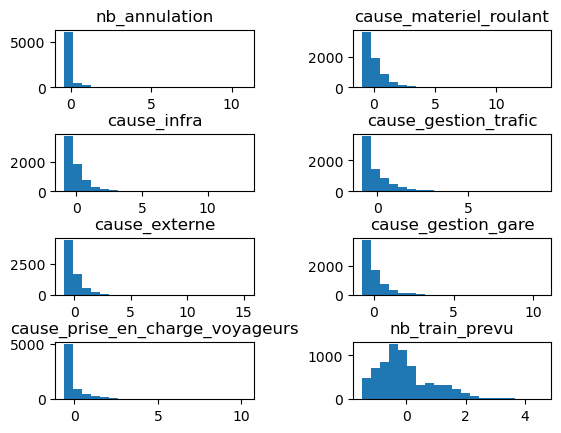

In [188]:
#Visualisation des données
for i in range(len(causes_retards_large[:])):
    plt.subplot(4,2,i+1)
    plt.hist(df_retards[causes_retards_large[i]], bins = 20)
    plt.title(causes_retards_large[i])
    plt.gcf().subplots_adjust(wspace = 0.5, hspace = 0.8)

In [189]:
#Les données sont correctes, nous ne passerons pas au log ici

<span style="color: #D32F2F">**3. Première regression à une variable**</span>

Regression "rapide", pour récupérer le R^2, car nous nous intéresserons plus longuement au cas multivarié

In [190]:
#Appel de la fonction régression du fichier fonctions.py

reg_s = regression(df_retards[['cause_externe']], df_retards[['nb_train_retard_arrivee']])
results_s = reg[0]
print(results_s.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 4.911e+04
Date:                Sun, 18 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:23:48   Log-Likelihood:                -15276.
No. Observations:                5715   AIC:                         3.057e+04
Df Residuals:                    5706   BIC:                         3.063e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Le R^2, caractéristique du pouvoir explicatif du modèle, est d'environ 0.56 (1 correspondant à une prédiction parfaite). La variable cause_externe est significative.


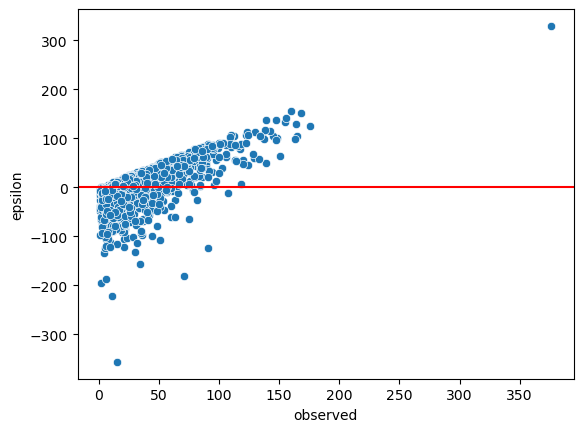

In [191]:
#Visualisation de l'erreur (fonction visu_erreur du fichier fonctions.py)
xTest = reg[2]
yTest = reg_s[4]
yPred = results_s.predict(xTest)
visu_erreur(yPred, yTest)


In [192]:
#Le modèle souffre clairement d'un problème de spécification

<span style="color: #D32F2F">**4. Regression à plusieurs variables**</span>

In [193]:
#On passe maintenant à une regression à plusieurs variables
reg = regression(df_retards[causes_retards_large], df_retards[['nb_train_retard_arrivee']])
results = reg[0]
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 5.921e+04
Date:                Sun, 18 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:23:49   Log-Likelihood:                -14864.
No. Observations:                5715   AIC:                         2.975e+04
Df Residuals:                    5706   BIC:                         2.981e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     


**Analyse des coefficients**

Le R^2 de la regression est satisfaisant et a largement augmenté (en ajoutant des variables, on augmente le pouvoir explicatif du modèle sous certaines conditions). La variable nb_annulation n'est pas significative et nb_train_prevu n'est pas significative au seuil de 1%. Le reste des variables sont significatives.
Le coefficient le plus élevé est celui de cause_externe. Il signifie qu'une cause externe provoque le retard d'environ 9 trains en moyenne. On va utiliser le lasso pour sélectionner les variables.

In [194]:
#récupération des variables xTest et yTest renvoyées par la fonction regression
xTest = reg[2]
yTest = reg[4]
yPred = results.predict(xTest)
epsilon = yTest - yPred

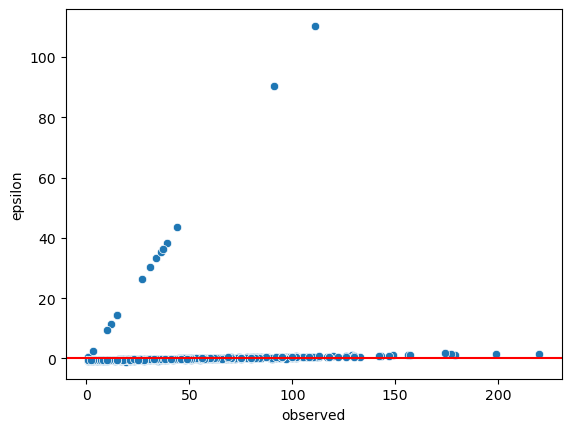

In [195]:
#Nuage de points de l'erreur en fonction des variables observées (fonction visu_erreur dans le fichier fonctions.py)
visu_erreur(yPred, yTest)

In [196]:
#Nous avons ici encore un problème de spécification du modèle

<span style="color: #D32F2F">**5. Sélection de variables avec le lasso**</span>

In [197]:
df_retards = df_retards_initial.copy()
#on commence par refaire une regression

reg = regression(df_retards[causes_retards_large], df_retards[['nb_train_retard_arrivee']])
results = reg[0]
xTrain = reg[1]
yTrain = reg[3]

In [198]:
#Estimation du modèle LASSO
lasso1 = Lasso(fit_intercept=True,normalize=False, alpha = 0.7).fit(xTrain,yTrain)
x = sm.add_constant(df_retards[causes_retards_large])

#selection de variables
features_selec = x.columns[np.abs(lasso1.coef_)>0].tolist()
features_selec 

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


['cause_materiel_roulant',
 'cause_infra',
 'cause_gestion_trafic',
 'cause_externe',
 'cause_gestion_gare',
 'cause_prise_en_charge_voyageurs',
 'nb_train_prevu']

In [199]:
#On ne retient pas la variable nb_annulation ce qui est assez intuitif (pour la plupart des tests lasso, si ce nest pas le cas refaire tourner la cellule).

In [200]:
#Recalibrage des données
features = df_retards[features_selec]
features = StandardScaler().fit(features.values).transform(features.values)
df_retards[features_selec] = features

In [201]:
#corrélations entre les variables sélectionnées
corr = df_retards[features_selec].corr()

plt.figure()
p = corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)
p

/tmp/ipykernel_725/2425215618.py:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  p = corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)


,cause_materiel_roulant,cause_infra,cause_gestion_trafic,cause_externe,cause_gestion_gare,cause_prise_en_charge_voyageurs,nb_train_prevu
cause_materiel_roulant,1.00,0.47,0.52,0.43,0.53,0.36,0.61
cause_infra,0.47,1.00,0.56,0.50,0.41,0.31,0.56
cause_gestion_trafic,0.52,0.56,1.00,0.45,0.48,0.37,0.48
cause_externe,0.43,0.50,0.45,1.00,0.35,0.28,0.53
cause_gestion_gare,0.53,0.41,0.48,0.35,1.00,0.46,0.53
cause_prise_en_charge_voyageurs,0.36,0.31,0.37,0.28,0.46,1.00,0.51
nb_train_prevu,0.61,0.56,0.48,0.53,0.53,0.51,1.00


<Figure size 640x480 with 0 Axes>

On vérifie que les variables ne sont pas exagérément correlées (c'est plutôt correct ici, à part la variable nb_train_prevu qui peut être limite. 

In [202]:
#Régression avec les variables selectionnées par le lasso
results_2 = regression(df_retards[features_selec], df_retards[['nb_train_retard_arrivee']])[0]

print(results_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 6.823e+04
Date:                Sun, 18 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:23:53   Log-Likelihood:                -14814.
No. Observations:                5715   AIC:                         2.964e+04
Df Residuals:                    5707   BIC:                         2.970e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

On va retirer la variable nb_train_prevu qui n'est pas significative au seuil de 1%, qui était la plus corrélée avec les autres, et qui est de plus moins intuitive pour prédire le nombre de retards. On retire cause_gestion_trafic qui était aussi plus corréleée aux autres variables.

In [203]:
#Régression finale 
reg_3 = regression(df_retards[['cause_materiel_roulant','cause_infra','cause_externe','cause_gestion_gare','cause_prise_en_charge_voyageurs','nb_train_prevu']], df_retards[['nb_train_retard_arrivee']])
results_3 = reg_3[0]

print(results_3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 1.517e+04
Date:                Sun, 18 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:23:55   Log-Likelihood:                -19404.
No. Observations:                5715   AIC:                         3.882e+04
Df Residuals:                    5708   BIC:                         3.887e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

**Conclusion** : selon cette regression, l'incident impliquant le plus de retard est la cause externe (météo...). Lorsqu'on observe un incident externe de plus, on prédit le retard de 9 à 10 trains supplémentaires. Malheureusement, la SNCF ne peut pas vraiment agir sur ce genre d'incidents. 
En revanche, si la SNCF trouvait par exemple un moyen de supprimer les problèmes de matériel roulant, elle éviterait le retard de 6 à 7 trains par ligne et par mois. 
Ce qui est plus embêtant pour la SNCF est qu'aucune cause de retard ne "sort du lot" en terme d'impact donc la SNCF doit agir sur l'ensemble de ces causes pour réduire les retards.


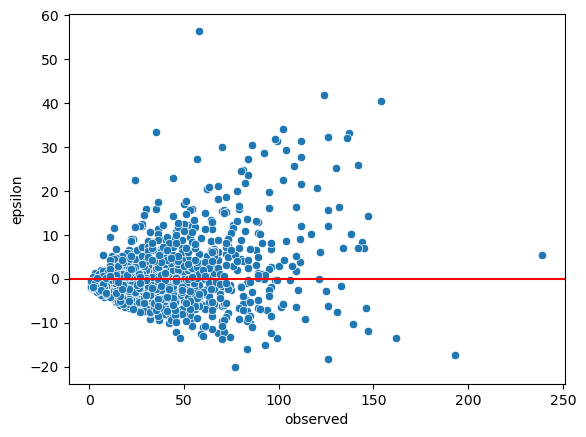

In [204]:
xTest = reg_3[2]
yTest = reg_3[4]
yPred = results_3.predict(xTest)
visu_erreur(yPred, yTest)

Le modèle est définitivement meilleur bien que le R^2 ait diminué. Le R^2 augmente mécaniquement avec le nombre de variables mais il n'est pas toujours pertinent de retenir toutes les variables.